In [1]:
%matplotlib inline
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input

from glob import glob
from itertools import cycle,zip_longest

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import json
import time

from sklearn.cluster import KMeans

import numpy as np
import lda
import collections

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Processing - Create Batch Generator

In [2]:
#run extract_files.py to process the image files
total_image_number = 206900

## Process .json file with image labels 

In [3]:
def process_label_file():
    #with open("photos.json") as infile:
    with open("../photos.json") as infile:
      val = infile.readlines()

    id = []
    label = []
    for i in val:
      #print(i)
      #print("ID: %s, Label: %s" % (json.loads(i)['photo_id'],json.loads(i)['label']))
      id.append(json.loads(i)['photo_id'])
      label.append(json.loads(i)['label'])
    id = np.asarray(id)
    label = np.asarray(label)
    info = np.vstack((id,label))
    info = info.T
    info[0,:]
    return info

In [4]:
#align images with labels in used_im_labels array
def map_label_file_to_names(json_labels,names):
    process_names = names
    new_names = [(name.replace("/home/ubuntu/project/le49/photos/","")).replace(".jpg","") for name in process_names]
    used_im_labels = [json_labels[np.where(json_labels[:,0]==name)[0][0],1] for name in new_names]
    return np.asarray(used_im_labels)

In [5]:
info = process_label_file()

In [6]:
#used_im_labels = map_label_file_to_names(info,names)
#np.save('labels.npy', used_im_labels) 

In [7]:
used_im_labels = np.load('labels.npy')

In [8]:
#number of clusters
uniq_elem = np.unique(info[:,1])

## Define Model

In [9]:
# refer to extract_files.py for model definiton

## Load Extracted Features

In [9]:
#refer to extract_files.py for creation of these files
names = np.load('names.npy')

In [10]:
final_features_b2_av = np.load('predictions_block2_global.npy')

In [11]:
final_features_b5_av = np.load('predictions_block5_global.npy')

In [12]:
final_features_b2_max = np.load('predictions_block2_max.npy')

In [13]:
final_features_b5_max = np.load('predictions_block5_max.npy')

## Process features into word representations

** Process by normalising the rows and setting values > 0.5 to 1 otherwise 0 **

In [25]:
def process_features_with_normalising(final_features):
    processed_features_list = []
    mean = np.mean(final_features,axis=1)
    min = np.min(final_features,axis=1)
    max = np.max(final_features,axis=1)
    for row in range(final_features.shape[0]):
      if((100*row/final_features.shape[0]) % 10 == 0 and int(100*row/final_features.shape[0]) !=0):
          print("%s" % (int(100*row/final_features.shape[0])))
      normalised_row = [(image-min[row])/(max[row]-min[row]) for image in final_features[row,:]]
      discrete_row = [1 if image >= 0.5 else 0 for image in normalised_row]
      final_array_row = np.asarray(discrete_row)
      processed_features_list.append(final_array_row)
    return np.asarray(processed_features_list)

In [26]:
#processed_features_b5_av_norm = process_features_with_normalising(final_features_b5_av)
#processed_features_b5_max_norm = process_features_with_normalising(final_features_b5_max)
#processed_features_b2_av_norm = process_features_with_normalising(final_features_b2_av)
#processed_features_b2_max_norm = process_features_with_normalising(final_features_b2_max)

10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90
10
20
30
40
50
60
70
80
90


In [27]:
#np.save('processed_features_b5_av_norm.npy', processed_features_b5_av_norm) 
#np.save('processed_features_b5_max_norm.npy', processed_features_b5_max_norm) 
#np.save('processed_features_b2_av_norm.npy', processed_features_b2_av_norm) 
#np.save('processed_features_b2_max_norm.npy', processed_features_b2_max_norm) 

In [142]:
#processed_features_b5_av_norm = np.load('processed_features_b5_av_norm.npy')
#processed_features_b5_max_norm = np.load('processed_features_b5_max_norm.npy')
#processed_features_b2_av_norm = np.load('processed_features_b2_av_norm.npy')
#processed_features_b2_max_norm = np.load('processed_features_b2_max_norm.npy')

In [24]:
def process_features_with_counts(final_features):
    num_features = final_features.shape[1]
    return np.reshape(np.round(np.reshape(final_features,(total_image_number*num_features))),(total_image_number,num_features)).astype(int)

In [21]:
#processed_features_b5_av_counts = process_features_with_counts(final_features_b5_av)
#processed_features_b5_max_counts = process_features_with_counts(final_features_b5_max)
#processed_features_b2_av_counts = process_features_with_counts(final_features_b2_av)
#processed_features_b2_max_counts = process_features_with_counts(final_features_b2_max)

In [22]:
#np.save('processed_features_b5_av_counts.npy', processed_features_b5_av_counts) 
#np.save('processed_features_b5_max_counts.npy', processed_features_b5_max_counts) 
#np.save('processed_features_b2_av_counts.npy', processed_features_b2_av_counts) 
#np.save('processed_features_b2_max_counts.npy', processed_features_b2_max_counts) 

In [14]:
processed_features_b5_av_counts = np.load('processed_features_b5_av_counts.npy')
processed_features_b5_max_counts = np.load('processed_features_b5_max_counts.npy')
processed_features_b2_av_counts = np.load('processed_features_b2_av_counts.npy')
processed_features_b2_max_counts = np.load('processed_features_b2_max_counts.npy')

In [15]:
def regenerate_random_data_samples(total_samples,random_subset, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    final_subset = features[random_subset][0,:,:]
    final_labels = used_im_labels[random_subset][0]
    final_names = names[random_subset][0]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names


In [74]:
def generate_random_data_samples(total_samples, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    random_subset = np.random.choice(range(0,processed_features.shape[0]), size=(total_samples), replace=False)
    final_subset = features[random_subset]
    final_labels = used_im_labels[random_subset]
    final_names = names[random_subset]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names



In [57]:
final_subset, final_labels, random_subset,names_subset= generate_random_data_samples(2000)

In [58]:
collections.Counter(final_labels)

Counter({'drink': 68, 'food': 1259, 'inside': 478, 'menu': 15, 'outside': 180})

In [36]:
collections.Counter(used_im_labels)

Counter({'drink': 6618,
         'food': 132325,
         'inside': 47948,
         'menu': 894,
         'outside': 19115})

In [59]:
np.save("subset_test1.npy",random_subset) 

In [ ]:
random_subset = np.load("complete_random_subset_working.npy")

In [ ]:
random_subset = np.load("complete_random_subset_working_2.npy")

In [16]:
random_subset = np.load("subset_test1.npy") #~1% data (same distribution)! FINAL

In [17]:
final_subset_b5_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_av_counts) # max 894


In [18]:
final_subset_b5_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_max_counts) # max 894



In [19]:
final_subset_b2_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_av_counts) # max 894 


In [81]:
collections.Counter(final_labels)

Counter({'drink': 68, 'food': 1259, 'inside': 478, 'menu': 15, 'outside': 180})

In [83]:
final_subset_b5_av.shape

(2000, 512)

## Do LDA on word representations

In [20]:
model_lda_b5_av_topic_c_10 = np.load("./final_data/model_lda_b5_av_topic_c_10.npy")
model_lda_b2_av_topic_c_10 = np.load("./final_data/model_lda_b2_av_topic_c_10.npy")
model_lda_b5_max_topic_c_10 = np.load("./final_data/model_lda_b5_max_topic_c_10.npy")
model_lda_b5_av_topic_c_5 = np.load("./final_data/model_lda_b5_av_topic_c_5.npy")
model_lda_b5_av_topic_c_40 = np.load("./final_data/model_lda_b5_av_topic_c_40.npy")
model_lda_b5_av_comp_c_10 = np.load("./final_data/model_lda_b5_av_comp_c_10.npy")
model_lda_b2_av_comp_c_10 = np.load("./final_data/model_lda_b2_av_comp_c_10.npy")
model_lda_b5_max_comp_c_10 = np.load("./final_data/model_lda_b5_max_comp_c_10.npy")
model_lda_b5_av_comp_c_5 = np.load("./final_data/model_lda_b5_av_comp_c_5.npy")
model_lda_b5_av_comp_c_40 = np.load("./final_data/model_lda_b5_av_comp_c_40.npy")
model_lda_b5_av_ndz_c_10 = np.load("./final_data/model_lda_b5_av_ndz_c_10.npy")
model_lda_b2_av_ndz_c_10 = np.load("./final_data/model_lda_b2_av_ndz_c_10.npy")
model_lda_b5_max_ndz_c_10 = np.load("./final_data/model_lda_b5_max_ndz_c_10.npy")
model_lda_b5_av_ndz_c_5 = np.load("./final_data/model_lda_b5_av_ndz_c_5.npy")
model_lda_b5_av_ndz_c_40 = np.load("./final_data/model_lda_b5_av_ndz_c_40.npy")


In [21]:
tsne_weights_b5_av_c_p40_5 = np.load("./final_data/tsne_weights_b5_av_c_p40_5.npy")
tsne_weights_b5_av_c_p40_40 = np.load("./final_data/tsne_weights_b5_av_c_p40_40.npy")
tsne_weights_b5_av_c_p40_10 = np.load("./final_data/tsne_weights_b5_av_c_p40_10.npy")
tsne_weights_b2_av_c_p40_10 = np.load("./final_data/tsne_weights_b2_av_c_p40_10.npy")
tsne_weights_b5_max_c_p40_10= np.load("./final_data/tsne_weights_b5_max_c_p40_10.npy")

In [22]:
labels_b2_av_c_p40_10 = np.load("./final_data/labels_b2_av_c_p40_10.npy")
labels_b5_av_c_p40_10 = np.load("./final_data/labels_b5_av_c_p40_10.npy")
labels_b5_av_c_p40_5 = np.load("./final_data/labels_b5_av_c_p40_5.npy")
labels_b5_av_c_p40_40 = np.load("./final_data/labels_b5_av_c_p40_40.npy")
labels_b5_max_c_p40_10 = np.load("./final_data/labels_b5_max_c_p40_10.npy")

In [23]:
std_lda_b5_av_c_10 = np.load("./final_data/std_lda_b5_av_c_10.npy")
std_lda_b2_av_c_10 = np.load("./final_data/std_lda_b2_av_c_10.npy")
std_lda_b5_max_c_10 = np.load("./final_data/std_lda_b5_max_c_10.npy")
std_lda_b5_av_c_5 = np.load("./final_data/std_lda_b5_av_c_5.npy")
std_lda_b5_av_c_40 = np.load("./final_data/std_lda_b5_av_c_40.npy")

In [32]:
model1 = model_lda_b5_av_topic_c_40
model2 = model_lda_b5_max_topic_c_10

In [33]:
lowDWeights1 = tsne_weights_b5_av_c_p40_40
lowDWeights2 = tsne_weights_b5_max_c_p40_10
labels1 = labels_b5_av_c_p40_40
labels2 = labels_b5_max_c_p40_10
class_count_1 = collections.Counter(labels1)
class_count_2 = collections.Counter(labels2)
std1 = std_lda_b5_av_c_10
std2 = std_lda_b5_max_c_10

In [26]:
labels = final_labels

In [27]:
from sklearn.metrics.cluster import adjusted_rand_score

In [28]:
adjusted_rand_score(np.argmax(model1,axis=1),np.argmax(model2,axis=1))

0.3717287641980588

In [52]:
def save_hist_plot_as_txt(x,y,fname):
    with open(fname, 'w') as f:
          f.write("x y\n")
          for i in range(x.shape[0]):
            if(i < y.shape[0]):
                f.write("%s %s\n" %(x[i],y[i]))
            else:
                f.write("%s\n" %(x[i]))
                print("here")

here


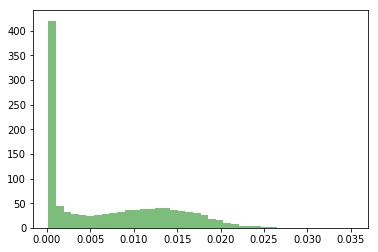

In [53]:
save_hist_plot_as_txt(plt.hist(std_lda_b5_av_c_10,bins=40,alpha = 0.3,normed=True,color ='green')[1],plt.hist(std_lda_b5_av_c_10,bins=40,alpha = 0.3,normed=True,color ='green')[0],"output_plots/test.txt")

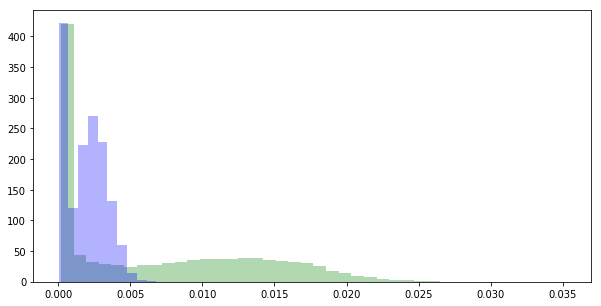

In [85]:
plt.figure(figsize=(10, 5))
plt.hist(std_lda_b5_av_c_10,bins=40,alpha = 0.3,normed=True,color ='green')
plt.hist(std_lda_b5_max_c_10,bins=10,alpha = 0.3,normed=True,color ='blue')
#plt.hist(std_lda_b5_av_c_5,bins=10,alpha = 0.3,normed=True,color ='red')
#plt.hist(std_lda_b5_av_c_40,bins=10,alpha = 0.3,normed=True,color ='orange')
#plt.hist(std_lda_b2_av_c_10,bins=40,alpha = 0.3,normed=True,color ='cyan')
plt.show()

(40,)

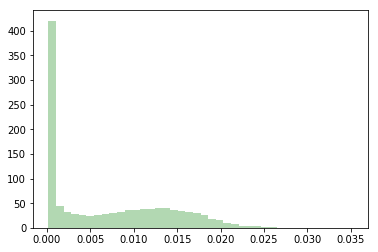

In [51]:
plt.hist(std_lda_b5_av_c_10,bins=40,alpha = 0.3,normed=True,color ='green')[0].shape

<function matplotlib.pyplot.show>

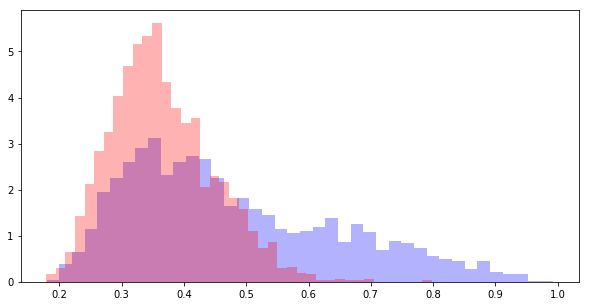

In [82]:
plt.figure(figsize=(10, 5))
plt.hist(np.max(model_lda_b5_av_topic_c_10,axis=1),bins=40,alpha = 0.3,normed=True, color = 'blue')
plt.hist(np.max(model_lda_b2_av_topic_c_10,axis=1),bins=40,alpha = 0.3,normed=True, color= 'red')
plt.show

In [80]:
model_lda_b5_av_topic_c_10[1,:]

array([2.63755102e-01, 8.16326531e-05, 1.15102041e-02, 1.40489796e-01,
       8.16326531e-05, 1.29877551e-01, 8.16326531e-05, 8.16326531e-05,
       2.91510204e-01, 1.62530612e-01])

## Visualisation of LDA wrt image labels

In [36]:
# RE-IMPLEMENT!!!
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(10, 10))  #in inches

    for i,label in enumerate(labels):
        
        x, y = lowDWeights[i,:]
        if label == 'menu': #negative
            plt.scatter(x, y,c='orange')
        elif label == 'drink': #neutral
            plt.scatter(x, y,c='green')
        elif label == 'inside': #neutral
            plt.scatter(x, y,c='blue')
        elif label == 'outside': #neutral
            plt.scatter(x, y,c='yellow')
        elif label == 'food': #neutral
            plt.scatter(x, y,c='purple')
        #plt.annotate(i,
        #         xy=(x, y),
        #         xytext=(5, 2),
        #       textcoords='offset points',
        #        ha='right',
        #         va='bottom')

    #plt.savefig(filename)

In [29]:
def save_tsne_plot_as_txt(tsne_low_dim_rep,labels1,labels2,fname):
    with open(fname, 'w') as f:
          f.write("x y l1 l2\n")
          for i in range(tsne_low_dim_rep.shape[0]):
            f.write("%s %s %s %s\n" %(tsne_low_dim_rep[i,0],tsne_low_dim_rep[i,1],labels1[i],labels2[i]))

In [31]:
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_5,labels_b5_av_c_p40_5,new_labels,"./output_plots/tsne_b5_av_c_p40_5.txt")
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_10,labels_b5_av_c_p40_10,new_labels,"./output_plots/tsne_b5_av_c_p40_10.txt")
save_tsne_plot_as_txt(tsne_weights_b5_av_c_p40_40,labels_b5_av_c_p40_40,new_labels,"./output_plots/tsne_b5_av_c_p40_40.txt")
save_tsne_plot_as_txt(tsne_weights_b5_max_c_p40_10,labels_b5_max_c_p40_10,new_labels,"./output_plots/tsne_b5_max_c_p40_10.txt")
save_tsne_plot_as_txt(tsne_weights_b2_av_c_p40_10,labels_b2_av_c_p40_10,new_labels,"./output_plots/tsne_b2_av_c_p40_10.txt")

In [30]:
new_labels = []
for label in labels:
    if label == 'menu': #negative
        new_labels.append(0)
    elif label == 'drink': #neutral
        new_labels.append(1)
    elif label == 'inside': #neutral
        new_labels.append(2)
    elif label == 'outside': #neutral
        new_labels.append(3)
    elif label == 'food': #neutral
        new_labels.append(4)
new_labels = np.asarray(new_labels)

In [37]:
labels_b2_av_c_p40_10 = np.load("./final_data/labels_b2_av_c_p40_10.npy")
labels_b5_av_c_p40_10 = np.load("./final_data/labels_b5_av_c_p40_10.npy")
labels_b5_av_c_p40_5 = np.load("./final_data/labels_b5_av_c_p40_5.npy")
labels_b5_av_c_p40_40 = np.load("./final_data/labels_b5_av_c_p40_40.npy")
labels_b5_max_c_p40_10 = np.load("./final_data/labels_b5_max_c_p40_10.npy")

In [38]:
tsne_weights_b5_av_c_p40_5 = np.load("./final_data/tsne_weights_b5_av_c_p40_5.npy")
tsne_weights_b5_av_c_p40_40 = np.load("./final_data/tsne_weights_b5_av_c_p40_40.npy")
tsne_weights_b5_av_c_p40_10 = np.load("./final_data/tsne_weights_b5_av_c_p40_10.npy")
tsne_weights_b2_av_c_p40_10 = np.load("./final_data/tsne_weights_b2_av_c_p40_10.npy")
tsne_weights_b5_max_c_p40_10= np.load("./final_data/tsne_weights_b5_max_c_p40_10.npy")

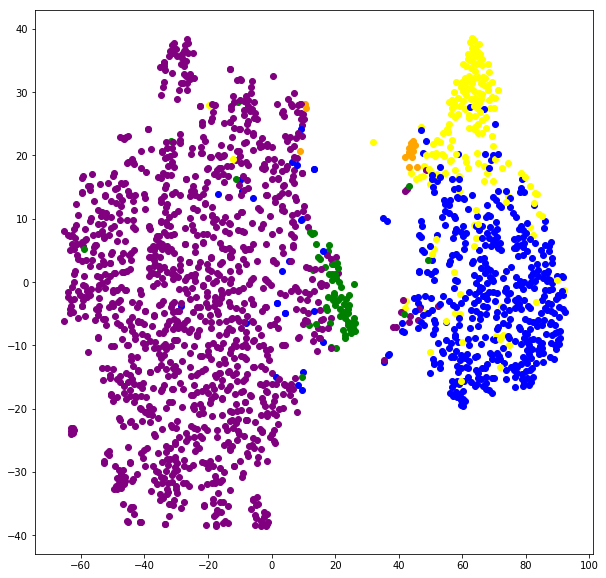

In [37]:
# 4 clusters p = 40
plot_with_labels(lowDWeights1, labels, str(1*100)+'.png')

MAX


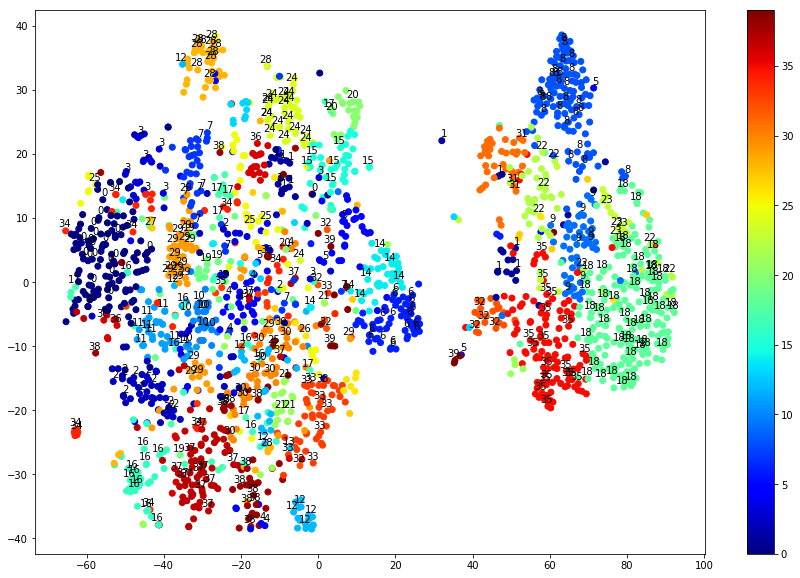

In [35]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("MAX")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=labels1,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
for i,label in enumerate(labels1):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



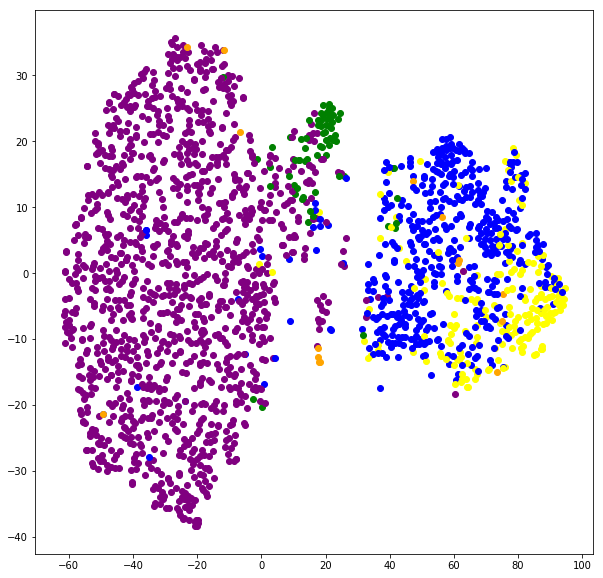

In [39]:
# 4 clusters p = 40
plot_with_labels(lowDWeights2, labels, str(1*100)+'.png')

AVERAGE
9


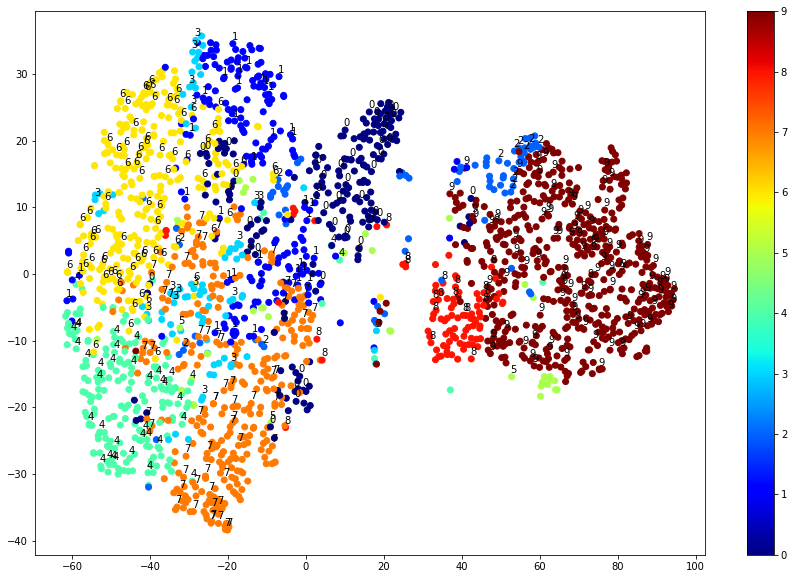

In [40]:
#cmap1 = plt.cm.get_cmap('jet', labels2)
print("AVERAGE")
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels2,cmap='jet')
#plt.legend(handles=[val])
plt.colorbar()
print(np.max(labels2))
for i,label in enumerate(labels2):
    x, y = lowDWeights2[i,:]
    if(i%5 == 0):
       plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




b2 av
class 0 - black, brown, white
class 2 - very dark - bright in the middle
class 5 - white background
class 7 - red coloured
class 8 - white green red

b5 av
class 2 - drinks
class 3 - inside + dark
class 6 - circular shaped foods (dark background) (6 and 9 close together)
class 9 - circular shaped foods (light background)
class 7 - outside

b5 max

class 0 - drinks
class 1- circular shaped foods (general)
class 2 - outside
class 3 - food, bright green, white plates
class 8 - people
class 9 - mixture between inside and outside


b5 av (5)

class 2 - text, menu, signs
class 4 - circular shaped foods (general)
class 0 - non-circular food
class 1 - inside
class 3 - combo of drink and food

b5 av (40)

class 6 - drinks
class 31 - text, menu, signs (majority menu only)
class 29 - sandwiches, burgers
class 30 - food, square plates
class 2 - brown meat
category 12 - brown plates/ wraps
category 22 - inside (wood, chairs)
category 18 - inside (dark, chairs at tables)
category 28 - pizza

114
[ 57  31  36  58  21  93  27  66   3  99   9  67  70  16   6  47  50   1
 111  20]


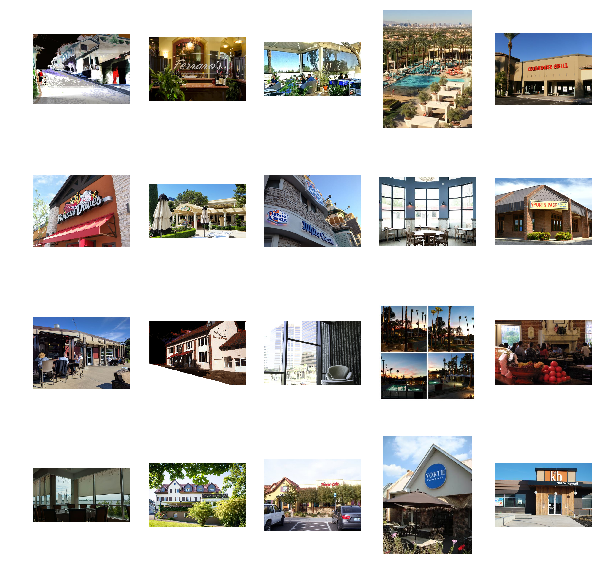

In [38]:
category = 8
option = 2
if option == 1:
    class_count = class_count_1[category]
    model = model1
else:
    class_count = class_count_2[category]
    model = model2
cat_ind = (np.argmax(model,axis=1) == category)
num_in_class = class_count
print(num_in_class)
if(num_in_class < 20):
    num_images = num_in_class
else:
    num_images = 20
with matplotlib.rc_context({'figure.figsize': [10,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    val = np.random.choice(range(0,num_in_class),size=(num_images),replace=False)
    print(val)
    for i,num in enumerate(range(0,num_images)):
        cat_names = names_subset[cat_ind] 
        img = PIL.Image.open(cat_names[val[i]])
        plt.subplot(4,5,i+1)
        plt.axis('off')
        plt.imshow(img)
        

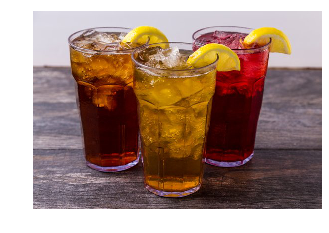

In [476]:
with matplotlib.rc_context({'figure.figsize': [30,25], 'axes.titlesize': 10}):
    fig = plt.figure()
    img = PIL.Image.open(names_subset[cat_ind][47])
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(img)

In [471]:
image_num = 55
#cat 11, im = 1224

NameError: name 'model_lda' is not defined

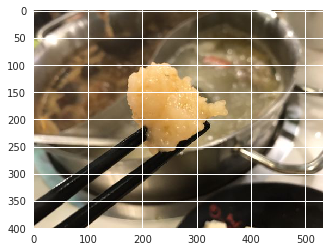

In [472]:
img = PIL.Image.open(names_subset[image_num])
plt.imshow(img)
class_val = np.argmax(model_lda.doc_topic_[image_num,:])
print(class_val)

In [88]:
print(np.argsort(model_lda.doc_topic_[image_num,:]))
model_lda.doc_topic_[image_num,:]

[ 0 17 16 12 11 18  8  9  6  4  3  2  1 19  5 10 13 14 15  7]


array([0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.1375, 0.0125, 0.1375,
       0.0125, 0.0125, 0.1375, 0.0125, 0.0125, 0.1375, 0.1375, 0.1375,
       0.0125, 0.0125, 0.0125, 0.0125])

<Container object of 20 artists>

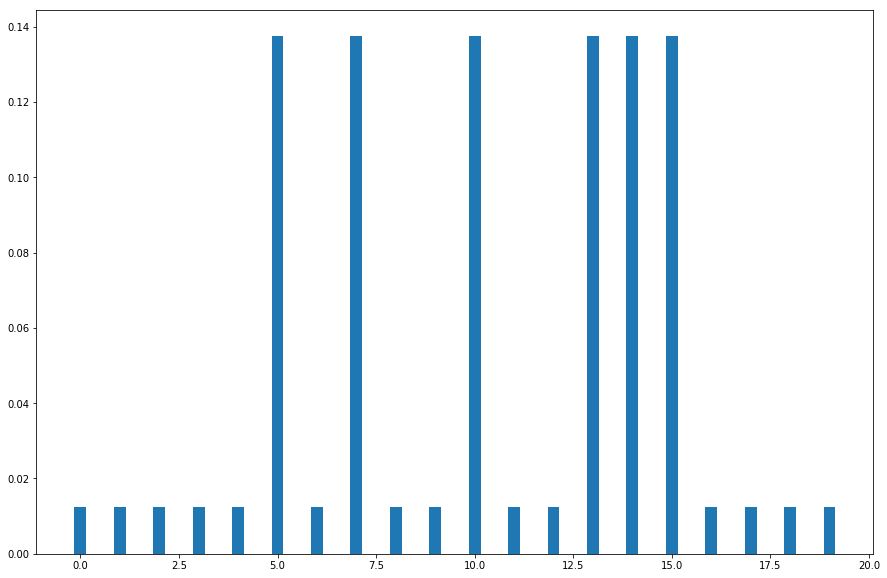

In [89]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,20),model_lda.doc_topic_[image_num,:],width=0.3)

In [326]:
category = 9
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]

In [327]:
len(indx)

640

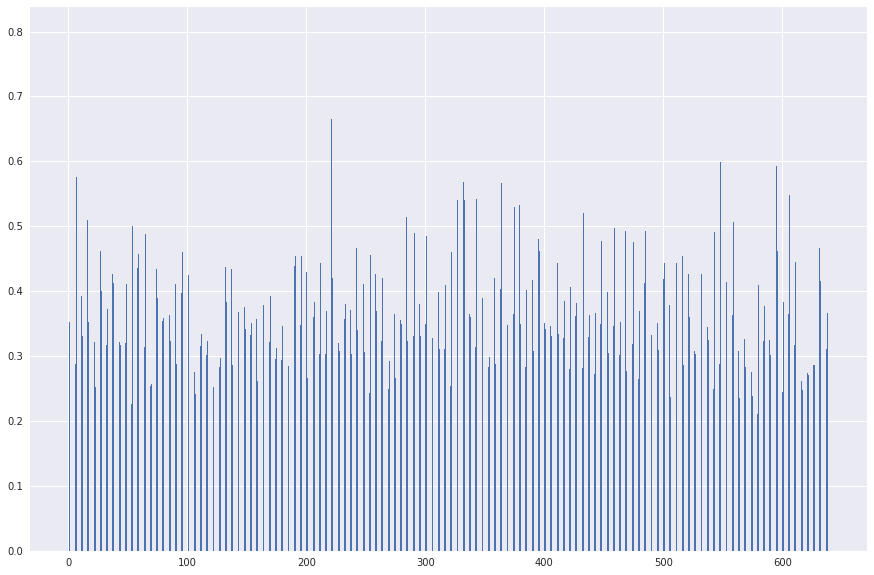

In [328]:
plt.figure(figsize=(15, 10))
#all_points = np.array(range(0,2000))
plt.bar(range(0,class_count_b2_av[category]),np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),width=0.3)
label_cat = indx
for i,label in enumerate(range(0,class_count_b2_av[category])):

    x = i
    y = np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1)[i]
    #plt.annotate(label_cat[i],xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')


In [331]:
np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1).shape

(640,)

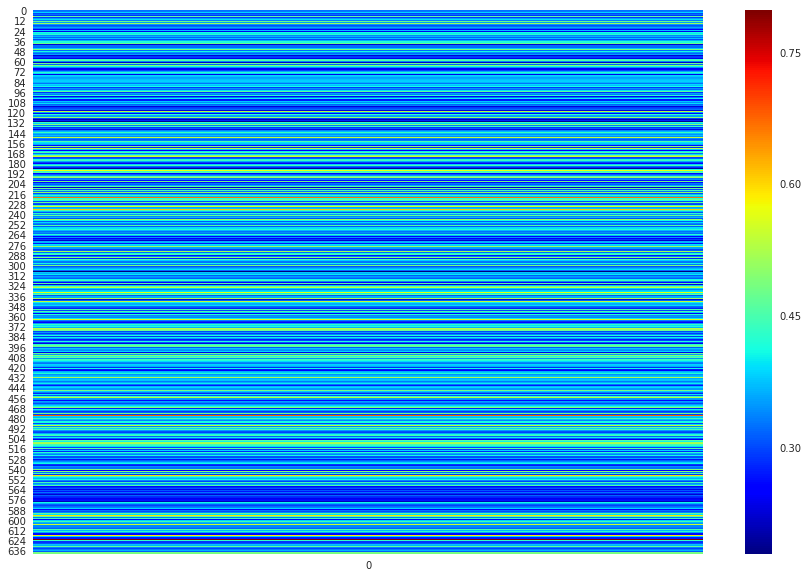

In [341]:
category = 9
sns.set()
num_in_class = class_count_b2_av[category]
cat = (np.argmax(model_lda_b2_av.doc_topic_,axis=1) == category)
indx = [i for i, x in enumerate(cat) if x]
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(np.reshape(np.max(model_lda_b2_av.doc_topic_[indx,:],axis=1),(num_in_class,1)),cmap="jet")

In [46]:
import seaborn as sns

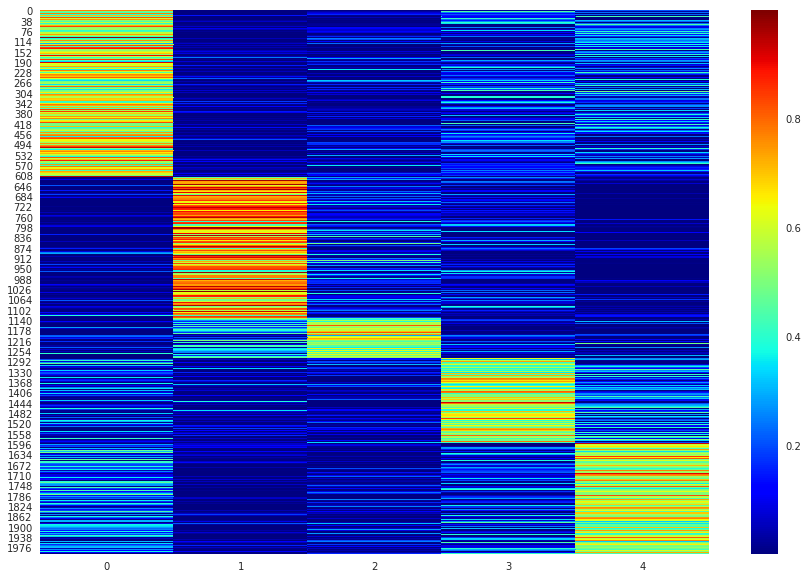

In [47]:
sns.set()
topic_ordered = np.argsort(np.argmax(model1,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model1[topic_ordered,:],cmap="jet")

## rich get richer - bigger clusters get bigger over time and smaller clusters get smaller (because of way update prior) so when topic number increases, the size of the clusters are relatively similar and can therefore find drink topics are more low level similarities

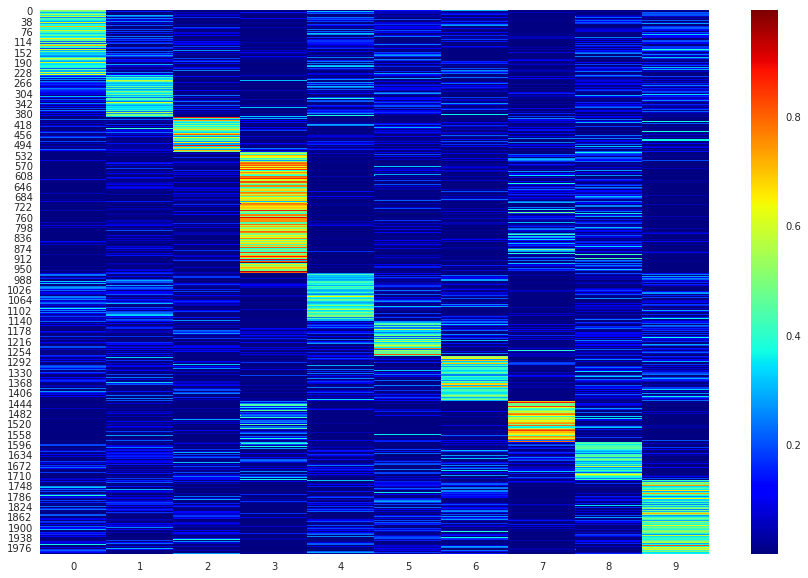

In [381]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av.doc_topic_ [topic_ordered,:],cmap="jet")

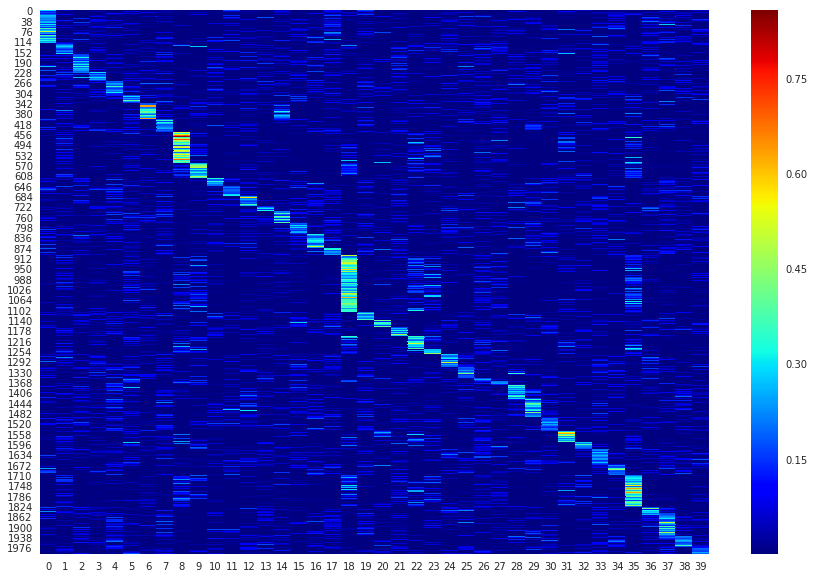

In [437]:
sns.set()
topic_ordered = np.argsort(np.argmax(model_lda_b5_av_40.doc_topic_,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(model_lda_b5_av_40.doc_topic_ [topic_ordered,:],cmap="jet")

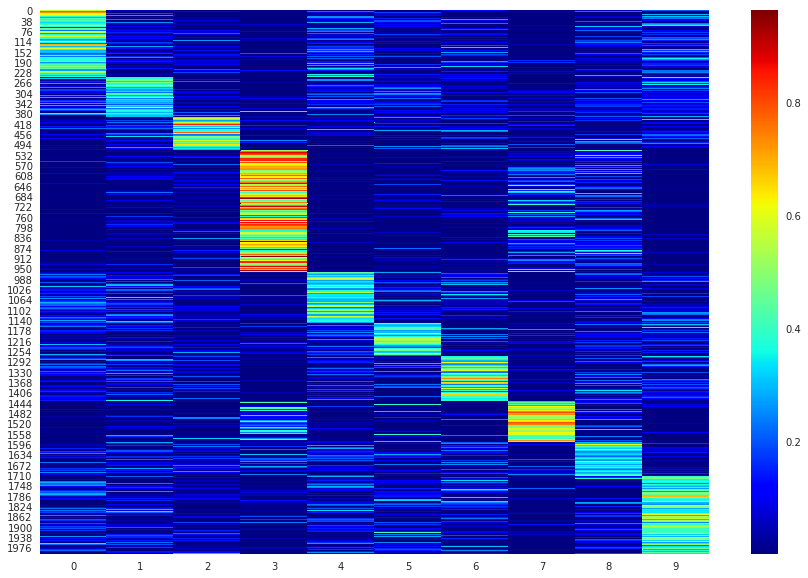

In [191]:
sns.set()
topic_ordered = np.argsort(np.argmax(topic_b5_av_c,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    sns.heatmap(topic_b5_av_c [topic_ordered,:],cmap="jet")

determining modesl given some words for a given topic 